In [1]:
from datetime import datetime
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

from utils import (
    get_mesh_files,
    load_data,
    advect_nodes,
    remesh,
    optimize_mesh,
    compute_mapping,
    get_area_ratio,
    resample_velocities
)

np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [2]:
mesh_init_file = r"D:\mesh_weddel_ease_25km_mmg_20_26.npz"
xc = np.load(mesh_init_file)['xc']
yc = np.load(mesh_init_file)['yc']
mask = np.load(mesh_init_file)['mask']
mask_f = gaussian_filter(mask.astype(float), 1, truncate=1)

In [5]:
force = False
min_edge_length = 13
max_edge_length = 38
min_edge_angle = 15
min_triangles = 5
search_dist = 50
max_dist0 = 50
min_area = 20
max_mask_fix_node=0.15
max_mask_zero_speed=0.6

sid_dir = r"D:\OSI-SAF\Preprocessing_Antarctica\2015"
lag_dir = r"D:\mesh_output"
ifiles = sorted(glob.glob(f'{sid_dir}/*.npz'))

idates = [datetime.strptime(os.path.basename(ifile).split('-')[-1].split('.')[0], '%Y%m%d%H%M%S')
          for ifile in ifiles]
print(len(ifiles), idates[0], idates[-1])

353 2015-01-01 12:00:00 2015-12-31 12:00:00


In [6]:
# MOVE MESH
for ifile, idate in tqdm(zip(ifiles, idates), total=len(ifiles)):
    mesh_src_file, mesh_dst_file = get_mesh_files(idate, lag_dir, mesh_init_file)
    if os.path.exists(mesh_dst_file) and not force:
        continue
    u, v, tri0 = load_data(ifile, mesh_src_file)
    u0, v0, fixed_nodes_idx = resample_velocities(u, v, mask_f, xc, yc, tri0.x, tri0.y, max_mask_fix_node, max_mask_zero_speed)
    tri_a = advect_nodes(tri0, u0, v0, max_dist0)
    tri_r = remesh(tri_a, fixed_nodes_idx, min_area, min_edge_length, min_edge_angle, max_edge_length)
    tri_o = optimize_mesh(tri_a, tri_r, fixed_nodes_idx)
    src2dst, weights = compute_mapping(tri_a, tri_o, search_dist)
    area_ratio = get_area_ratio(tri0, tri_a, tri_o, src2dst, weights)

    print(f'Save mesh file to {mesh_dst_file}')
    np.savez(mesh_dst_file, x=tri_o.x, y=tri_o.y, t=tri_o.triangles, src2dst=src2dst, weights=weights, ar=area_ratio)

 27%|████████████████████████▊                                                                    | 94/353 [00:00<00:00, 932.24it/s]

Load INIT
Load INIT
Load INIT
Load INIT
Load INIT
Load INIT
Load INIT


 52%|███████████████████████████████████████████████▋                                            | 183/353 [00:01<00:01, 160.89it/s]

NEGATIVE AREA!
17591
[17591 15520 18242]
[14307 10529 18237]
[]


IndexError: index 0 is out of bounds for axis 0 with size 0

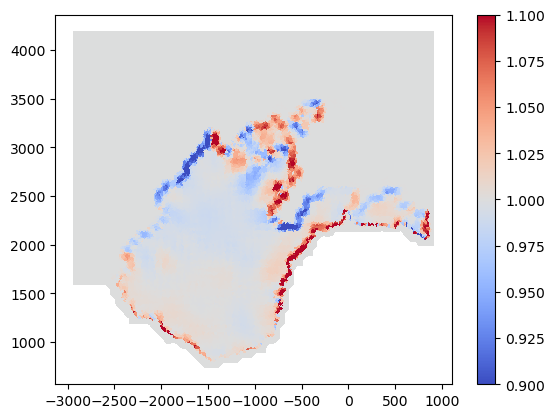

In [7]:
plt.tripcolor(tri_o, area_ratio, cmap='coolwarm', vmin=0.9, vmax=1.1)
plt.colorbar()

In [11]:
print(tri_o)